In [46]:
def compare_results(results1, results2, name1="Results 1", name2="Results 2"):
    """
    Compare two detection results dictionaries and display differences.
    
    Args:
        results1: First results dictionary
        results2: Second results dictionary
        name1: Label for first results
        name2: Label for second results
    """
    print(f"\n{'='*80}")
    print(f"COMPARISON: {name1} vs {name2}")
    print(f"{'='*80}\n")
    
    # Compare overall metrics
    print("OVERALL METRICS")
    print("-" * 80)
    overall1 = results1['overall']
    overall2 = results2['overall']
    
    for metric in ['total_gt', 'detected', 'recall']:
        val1 = overall1[metric]
        val2 = overall2[metric]
        diff = val2 - val1
        
        if metric == 'recall':
            pct_diff = ((val2 - val1) / val1 * 100) if val1 != 0 else 0
            print(f"{metric:12s}: {val1:.4f} → {val2:.4f} (Δ {diff:+.4f}, {pct_diff:+.2f}%)")
        else:
            pct_diff = ((val2 - val1) / val1 * 100) if val1 != 0 else 0
            print(f"{metric:12s}: {val1:6d} → {val2:6d} (Δ {diff:+6d}, {pct_diff:+.2f}%)")
    
    # Compare per-category metrics
    print("\n\nPER-CATEGORY METRICS")
    print("-" * 80)
    
    # Get all categories from both results
    categories1 = set(results1['per_category'].keys())
    categories2 = set(results2['per_category'].keys())
    all_categories = sorted(categories1 | categories2)
    
    for category in all_categories:
        cat1 = results1['per_category'].get(category)
        cat2 = results2['per_category'].get(category)
        
        print(f"\n{category.upper()}")
        
        if cat1 is None:
            print(f"  Only in {name2}: {cat2}")
            continue
        if cat2 is None:
            print(f"  Only in {name1}: {cat1}")
            continue
        
        for metric in ['total_gt', 'detected', 'recall']:
            val1 = cat1[metric]
            val2 = cat2[metric]
            diff = val2 - val1
            
            if metric == 'recall':
                pct_diff = ((val2 - val1) / val1 * 100) if val1 != 0 else 0
                print(f"  {metric:12s}: {val1:.4f} → {val2:.4f} (Δ {diff:+.4f}, {pct_diff:+.2f}%)")
            else:
                pct_diff = ((val2 - val1) / val1 * 100) if val1 != 0 else 0
                print(f"  {metric:12s}: {val1:6d} → {val2:6d} (Δ {diff:+6d}, {pct_diff:+.2f}%)")
    
    print(f"\n{'='*80}\n")

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import seaborn as sns

def compare_results(*results_list, names=None, show_plot=True, figsize=(16, 10)):
    """
    Compare multiple detection results dictionaries and display as graphics.
    
    Args:
        *results_list: Variable number of results dictionaries
        names: List of labels for each result set. If None, uses "Results 1", "Results 2", etc.
        show_plot: If True, displays matplotlib visualization. If False, prints table.
        figsize: Figure size for the plot (width, height)
    """
    if len(results_list) < 2:
        print("Error: At least 2 result sets are required for comparison")
        return
    
    # Generate names if not provided
    if names is None:
        names = [f"Results {i+1}" for i in range(len(results_list))]
    elif len(names) != len(results_list):
        print(f"Error: Number of names ({len(names)}) must match number of result sets ({len(results_list)})")
        return
    
    if not show_plot:
        # Fall back to text display
        _print_table_comparison(results_list, names)
        return
    
    # Set style
    sns.set_style("whitegrid")
    colors = plt.cm.Set2(np.linspace(0, 1, len(names)))
    
    # Get all categories
    all_categories = set()
    for results in results_list:
        all_categories.update(results['per_category'].keys())
    all_categories = sorted(all_categories)
    
    # Create OVERALL METRICS plot
    fig1, ax_overall = plt.subplots(1, 1, figsize=(figsize[0], 6))
    _plot_overall_metrics(ax_overall, results_list, names, colors)
    fig1.suptitle(f"Overall Performance: {' vs '.join(names)}", 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Create PER-CATEGORY METRICS plot
    n_categories = len(all_categories)
    fig2, axes = plt.subplots(1, n_categories, figsize=(figsize[0], 6))
    
    # Handle single category case
    if n_categories == 1:
        axes = [axes]
    
    for idx, category in enumerate(all_categories):
        _plot_category_metrics(axes[idx], results_list, names, category, colors)
    
    fig2.suptitle(f"Per-Categorie: {' vs '.join(names)}", 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()


def _plot_overall_metrics(ax, results_list, names, colors):
    """Plot overall metrics comparison."""
    metrics = ['detected', 'recall']
    x = np.arange(len(names))
    width = 0.35
    
    detected_values = [r['overall']['detected'] for r in results_list]
    recall_values = [r['overall']['recall'] * 100 for r in results_list]  # Convert to percentage
    
    # Create twin axis
    ax2 = ax.twinx()
    
    # Plot bars
    bars1 = ax.bar(x - width/2, detected_values, width, label='Detected', 
                   color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    bars2 = ax2.bar(x + width/2, recall_values, width, label='Recall %', 
                    color=colors, alpha=0.6, edgecolor='black', linewidth=1.5, hatch='//')
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars1, detected_values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(val)}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    for i, (bar, val) in enumerate(zip(bars2, recall_values)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{val:.1f}%',
                 ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Calculate and display percentage changes from baseline
    baseline_detected = detected_values[0]
    baseline_recall = recall_values[0]
    
    for i in range(1, len(names)):
        detected_change = ((detected_values[i] - baseline_detected) / baseline_detected) * 100
        recall_change = ((recall_values[i] - baseline_recall) / baseline_recall) * 100
        
        # Add change annotation
        y_pos = max(detected_values) * 0.05
        color = 'green' if detected_change > 0 else 'red'
        ax.text(i, y_pos, f'{detected_change:+.1f}%', 
                ha='center', va='bottom', fontsize=8, color=color, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=color, alpha=0.7))
    
    # Formatting
    ax.set_xlabel('Models', fontsize=12, fontweight='bold')
    ax.set_ylabel('Detected Count', fontsize=11, fontweight='bold', color='black')
    ax2.set_ylabel('Recall (%)', fontsize=11, fontweight='bold', color='black')
    ax.set_title('Overall', fontsize=13, fontweight='bold', pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=15, ha='right')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add legends
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left', framealpha=0.9)


def _plot_category_metrics(ax, results_list, names, category, colors):
    """Plot per-category metrics comparison."""
    x = np.arange(len(names))
    
    # Extract data
    recall_values = []
    detected_values = []
    
    for results in results_list:
        cat_data = results['per_category'].get(category)
        if cat_data:
            recall_values.append(cat_data['recall'] * 100)
            detected_values.append(cat_data['detected'])
        else:
            recall_values.append(0)
            detected_values.append(0)
    
    # Plot bars
    bars = ax.bar(x, recall_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for i, (bar, recall, detected) in enumerate(zip(bars, recall_values, detected_values)):
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{recall:.1f}%\n({detected})',
                    ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    # Add percentage change from baseline
    if recall_values[0] > 0:
        for i in range(1, len(names)):
            if recall_values[i] > 0:
                change = ((recall_values[i] - recall_values[0]) / recall_values[0]) * 100
                color = 'green' if change > 0 else 'red'
                y_pos = recall_values[i] * 0.1
                ax.text(i, y_pos, f'{change:+.1f}%',
                        ha='center', va='bottom', fontsize=7, color=color, fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', 
                                edgecolor=color, alpha=0.7, linewidth=1))
    
    # Formatting
    ax.set_title(category.upper(), fontsize=11, fontweight='bold', pad=8)
    ax.set_ylabel('Recall (%)', fontsize=9, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=25, ha='right', fontsize=8)
    ax.set_ylim(0, min(105, max(recall_values) * 1.2))
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=recall_values[0], color='blue', linestyle='--', alpha=0.3, linewidth=1, label='Baseline')


def _print_table_comparison(results_list, names):
    """Fallback text table display."""
    col_width = max(max(len(name) for name in names) + 2, 15)
    
    print(f"\n{'='*120}")
    print(f"COMPARISON: {' vs '.join(names)}")
    print(f"{'='*120}\n")
    
    print("OVERALL METRICS")
    print("-" * 120)
    
    metrics = ['total_gt', 'detected', 'recall']
    
    header = f"{'Metric':<12s} |"
    for name in names:
        header += f" {name:^{col_width}s} |"
    print(header)
    print("-" * 120)
    
    for metric in metrics:
        row = f"{metric:<12s} |"
        values = []
        
        for results in results_list:
            val = results['overall'][metric]
            values.append(val)
            
            if metric == 'recall':
                row += f" {val:>{col_width}.4f} |"
            else:
                row += f" {val:>{col_width}d} |"
        
        print(row)
    
    print(f"\n{'='*120}\n")


In [48]:
import json

label_agnostic = False  # Set to False for label-aware evaluation

if label_agnostic:
    results_gemini_2_5_pro = json.load(open('gemini_2_5_pro_eval_results_label_agnostic.json'))
    results_sam3_simple_prompt = json.load(open('sam3_simple_prompt_eval_results_label_agnostic.json'))
    results_sam3 = json.load(open('sam3_eval_results_label_agnostic.json'))
    results_usis_sam = json.load(open('usis_sam_eval_results_label_agnostic.json'))
else:
    results_gemini_2_5_pro = json.load(open('gemini_2_5_pro_eval_results.json'))
    results_sam3_simple_prompt = json.load(open('sam3_simple_prompt_eval_results.json'))
    results_sam3 = json.load(open('sam3_eval_results.json'))
    results_usis_sam = json.load(open('usis_sam_eval_results.json'))

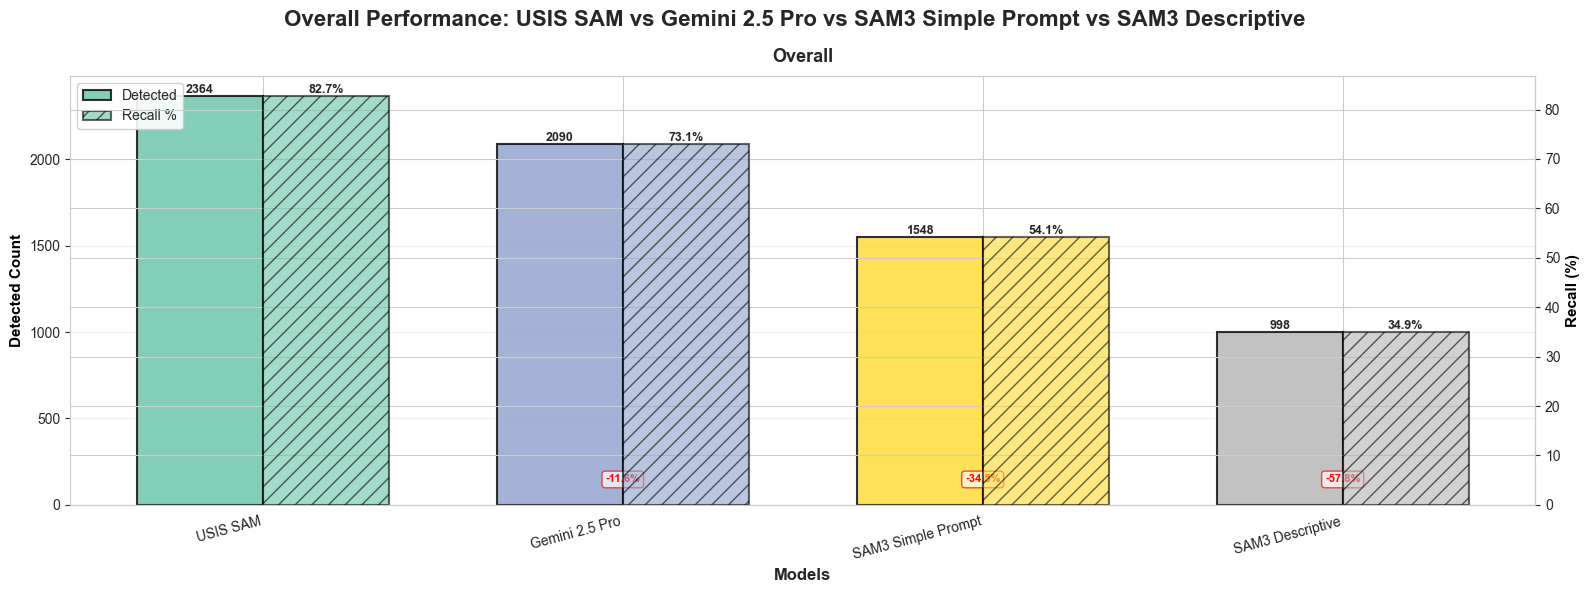

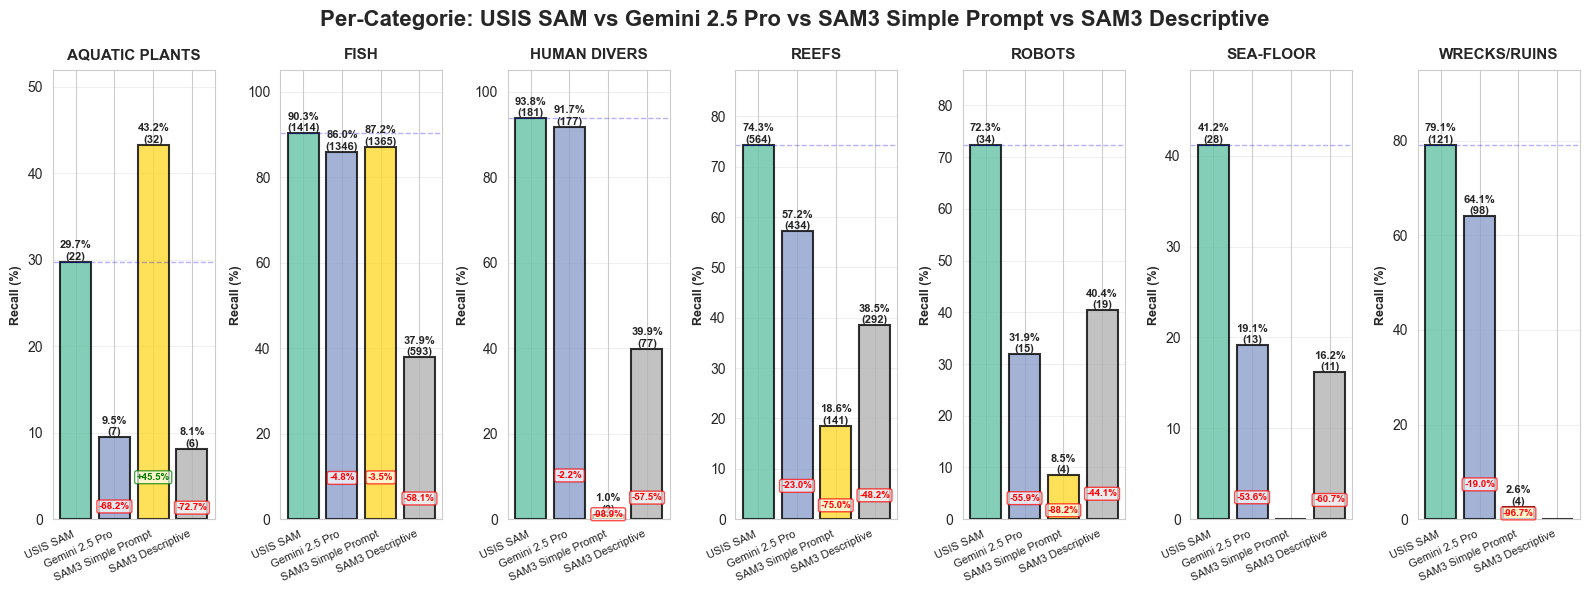

In [49]:
compare_results(results_usis_sam, results_gemini_2_5_pro, results_sam3_simple_prompt, results_sam3, 
                names=["USIS SAM", "Gemini 2.5 Pro", "SAM3 Simple Prompt", "SAM3 Descriptive"])